In [362]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [363]:
ROOT_DIR = "data"
TARGET = 'target'
RANDOM_STATE = 42
#RANDOM_STATE = 422

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 464 entries, Wip Line_Dam to target
dtypes: float64(350), int64(77), object(37)
memory usage: 143.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Columns: 465 entries, Set ID to target
dtypes: float64(351), int64(77), object(37)
memory usage: 61.6+ MB


In [364]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # 1. 데이터 그룹화 및 집계
# grouped_data = train_data.groupby(['Workorder_Dam', 'target']).size().unstack(fill_value=0)

# # 2. Workorder를 나누어서 서브플롯으로 그리기
# # 한 서브플롯에 표시할 Workorder의 수
# workorders_per_plot = 10

# # Workorder 값을 리스트로 변환
# workorder_list = grouped_data.index.tolist()

# # 총 서브플롯 개수 계산
# num_plots = int(np.ceil(len(workorder_list) / workorders_per_plot))

# # 서브플롯 그리기
# for i in range(num_plots):
#     # 현재 서브플롯에 표시할 Workorder 선택
#     subset_workorders = workorder_list[i * workorders_per_plot : (i + 1) * workorders_per_plot]
    
#     # 해당 Workorder에 해당하는 데이터만 선택
#     subset_data = grouped_data.loc[subset_workorders]
    
#     # 서브플롯 생성
#     subset_data.plot(kind='bar', stacked=True, figsize=(10, 6))
    
#     # 그래프 스타일과 레이블 설정
#     plt.title(f'Count of AbNormal and Normal by Workorder (Subset {i+1})')
#     plt.xlabel('Workorder')
#     plt.ylabel('Count')
#     plt.xticks(rotation=45)  # X축 라벨 회전
#     plt.legend(title='Target')
#     plt.tight_layout()  # 그래프 간격 자동 조절
    
#     # 그래프 출력
#     plt.show()


In [365]:
##데이터 전처리
# train_data = train_data.drop(columns=[col for col in train_data.columns if 'Workorder' in col])
# test_data = test_data.drop(columns=[col for col in test_data.columns if 'Workorder' in col])
train_data = train_data.drop(columns=[col for col in train_data.columns if 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value' in col])
test_data = test_data.drop(columns=[col for col in test_data.columns if 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value' in col])
train_data = train_data.drop(columns=[col for col in train_data.columns if 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value' in col])
test_data = test_data.drop(columns=[col for col in test_data.columns if 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value' in col])

train_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'] = train_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].apply(lambda x: 1 if x == 'OK' else 0)
test_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'] = test_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].apply(lambda x: 1 if x == 'OK' else 0)
# 값이 주어지지 않은 열 삭제
train_data = train_data.dropna(axis=1, how='all')
test_data = test_data.dropna(axis=1, how='all')
#상수열 제거
unique_value_counts = train_data.nunique()
columns_to_drop = unique_value_counts[unique_value_counts == 1].index
# 해당 열 제거
train_data = train_data.drop(columns=columns_to_drop)

unique_value_counts = test_data.nunique()
columns_to_drop = unique_value_counts[unique_value_counts == 1].index
# 해당 열 제거
test_data = test_data.drop(columns=columns_to_drop)



In [366]:
# import pandas as pd

# # Step 1: Workorder_Dam 기준으로 데이터 분리
# workorder_dam_groups = []
# workorder_dam_values = train_data["Workorder_Dam"].unique()

# for dam in workorder_dam_values:
#     workorder_dam_groups.append(train_data.loc[train_data["Workorder_Dam"] == dam])

# # Step 2: 각 Workorder_Dam 그룹에서 target 값으로 다시 분리
# train_data_workorder_dam_target = []

# for df in workorder_dam_groups:
#     target_values = df["target"].unique()
#     for target_val in target_values:
#         # 해당 target 값에 해당하는 데이터만 선택
#         target_specific_data = df.loc[df["target"] == target_val]
#         train_data_workorder_dam_target.append(target_specific_data)

# # # 나눈 데이터 출력 예시 (원하는 경우)
# # for i, data in enumerate(train_data_workorder_dam_target):
# #     print(f"Subset {i+1} - Rows: {len(data)}")
# #     print(data.head())
# train_data = pd.concat(train_data_workorder_dam_target)
# train_data = train_data.reset_index(drop = True)



In [367]:
target_class = train_data[TARGET]
train_data = train_data.drop(columns=[TARGET])

In [368]:
# Workorder별 등장 빈도 계산
workorder_freq = train_data["Workorder_Dam"].value_counts().reset_index()
workorder_freq.columns = ["Workorder_Dam", "WorkOrder_freq"]

# train_data에 병합
train_data = train_data.merge(workorder_freq, on="Workorder_Dam", how="left")

# test_data에도 병합 (비슷한 방식으로)
test_data = test_data.merge(workorder_freq, on="Workorder_Dam", how="left")

# 결측치 처리 (test_data에서 Workorder가 없는 경우)
test_data["WorkOrder_freq"].fillna(0, inplace=True)


In [369]:
# # Tact Time
# # Pallet ID
# # Production Qulatity

# # Tact Time별 등장 빈도 계산
# workorder_freq = train_data["Machine Tact time Collect Result_Dam"].value_counts().reset_index()
# workorder_freq.columns = ["Machine Tact time Collect Result_Dam", "TactTime_freq"]

# # train_data에 병합
# train_data = train_data.merge(workorder_freq, on="Machine Tact time Collect Result_Dam", how="left")

# # test_data에도 병합 (비슷한 방식으로)
# test_data = test_data.merge(workorder_freq, on="Machine Tact time Collect Result_Dam", how="left")

# # 결측치 처리 (test_data에서 Workorder가 없는 경우)
# test_data["TactTime_freq"].fillna(0, inplace=True)


# # Pallet별 등장 빈도 계산
# workorder_freq = train_data["PalletID Collect Result_Dam"].value_counts().reset_index()
# workorder_freq.columns = ["PalletID Collect Result_Dam", "PID_freq"]

# # train_data에 병합
# train_data = train_data.merge(workorder_freq, on="PalletID Collect Result_Dam", how="left")

# # test_data에도 병합 (비슷한 방식으로)
# test_data = test_data.merge(workorder_freq, on="PalletID Collect Result_Dam", how="left")

# # 결측치 처리 (test_data에서 Workorder가 없는 경우)
# test_data["PID_freq"].fillna(0, inplace=True)


# # QTY별 등장 빈도 계산
# workorder_freq = train_data["Production Qty Collect Result_Dam"].value_counts().reset_index()
# workorder_freq.columns = ["Production Qty Collect Result_Dam", "QTY_freq"]

# # train_data에 병합
# train_data = train_data.merge(workorder_freq, on="Production Qty Collect Result_Dam", how="left")

# # test_data에도 병합 (비슷한 방식으로)
# test_data = test_data.merge(workorder_freq, on="Production Qty Collect Result_Dam", how="left")

# # 결측치 처리 (test_data에서 Workorder가 없는 경우)
# test_data["QTY_freq"].fillna(0, inplace=True)


# # Tact Time별 등장 빈도 계산
# workorder_freq = train_data["Production Qty Collect Result_Fill1"].value_counts().reset_index()
# workorder_freq.columns = ["Production Qty Collect Result_Fill1", "QTY_Fill1_freq"]

# # train_data에 병합
# train_data = train_data.merge(workorder_freq, on="Production Qty Collect Result_Fill1", how="left")

# # test_data에도 병합 (비슷한 방식으로)
# test_data = test_data.merge(workorder_freq, on="Production Qty Collect Result_Fill1", how="left")

# # 결측치 처리 (test_data에서 Workorder가 없는 경우)
# test_data["QTY_Fill1_freq"].fillna(0, inplace=True)


# # Tact Time별 등장 빈도 계산
# workorder_freq = train_data["Receip No Collect Result_Fill1"].value_counts().reset_index()
# workorder_freq.columns = ["Receip No Collect Result_Fill1", "Receip_freq"]

# # train_data에 병합
# train_data = train_data.merge(workorder_freq, on="Receip No Collect Result_Fill1", how="left")

# # test_data에도 병합 (비슷한 방식으로)
# test_data = test_data.merge(workorder_freq, on="Receip No Collect Result_Fill1", how="left")

# # 결측치 처리 (test_data에서 Workorder가 없는 경우)
# test_data["Receip_freq"].fillna(0, inplace=True)


# # Tact Time별 등장 빈도 계산
# workorder_freq = train_data["Production Qty Collect Result_Fill2"].value_counts().reset_index()
# workorder_freq.columns = ["Production Qty Collect Result_Fill2", "QTY_Fill2_freq"]

# # train_data에 병합
# train_data = train_data.merge(workorder_freq, on="Production Qty Collect Result_Fill2", how="left")

# # test_data에도 병합 (비슷한 방식으로)
# test_data = test_data.merge(workorder_freq, on="Production Qty Collect Result_Fill2", how="left")

# # 결측치 처리 (test_data에서 Workorder가 없는 경우)
# test_data["QTY_Fill2_freq"].fillna(0, inplace=True)


# # Tact Time별 등장 빈도 계산
# workorder_freq = train_data["Receip No Collect Result_Fill2"].value_counts().reset_index()
# workorder_freq.columns = ["Receip No Collect Result_Fill2", "Receip2_freq"]

# # train_data에 병합
# train_data = train_data.merge(workorder_freq, on="Receip No Collect Result_Fill2", how="left")

# # test_data에도 병합 (비슷한 방식으로)
# test_data = test_data.merge(workorder_freq, on="Receip No Collect Result_Fill2", how="left")

# # 결측치 처리 (test_data에서 Workorder가 없는 경우)
# test_data["Receip2_freq"].fillna(0, inplace=True)


In [370]:
train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = (
    train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam']
    .replace('OK', 0)
    .astype(float)
)

train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = (
    train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1']
    .replace('OK', 0)
    .astype(float)
)

train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = (
    train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']
    .replace('OK', 0)
    .astype(float)
)
train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].fillna(0)
train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].fillna(0)
train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].fillna(0)
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].unique())
train_data.info()

[  0.  550.3 162.4 549.  549.5 550.  548.5]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 147 entries, Equipment_Dam to WorkOrder_freq
dtypes: float64(71), int64(64), object(12)
memory usage: 45.4+ MB


In [371]:
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = (
    test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam']
    .replace('OK', 0)
    .astype(float)
)

test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = (
    test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1']
    .replace('OK', 0)
    .astype(float)
)

test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = (
    test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2']
    .replace('OK', 0)
    .astype(float)
)
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].fillna(0)
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].fillna(0)
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].fillna(0)




# 확인을 위해 각 열의 타입 출력
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].unique())
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].unique())
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].unique())
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'].unique())
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].unique())
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'].unique())
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].unique())
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'].unique())
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'].unique())


test_data.info()

[  0.  550.3 162.4 549.  549.5 550.  548.5]
[  0.  838.4 837.7 837.9 838.2 837.5]
[  0.  835.5 305. ]
[550.5  463.8  162.4  465.5  462.5  463.   550.4  162.7  161.7  164.2
 550.6  551.5  551.3  463.5  161.2  462.75 465.3  551.7  552.   163.8
 548.9  551.8  465.1  163.5  550.3  164.1  551.2  164.   163.3  163.7
 552.1  462.2  549.4  550.7  164.5  163.1  551.6  163.4  163.6  163.
 551.  ]
[838.4 458.5 837.9 458.8 460.  837.4 837.7 459.5 458.7 838.1 458.2 459.2
 157.  838.2 156.1 459.  460.5 681.2]
[835.5 458.  305.  499.8 304.8]
[464.3 160.8 465.4 552.  159.5 160.5 463.7 465.7 464.7 467.1 465.5 463.9
 465.  464.6 160.  464.2 551.3 465.3 465.6 466.8 462.2 465.8 466.2 463.6
 464.8 466.7 466.  463.8 466.9 462.7 464.  467.5 466.1 464.9 466.3 466.6
 467.2 466.5 466.4 551.1]
[458.7 157.  458.1 157.5 458.4 457.8 458.3 458.8 838.4 457.6 457.9 458.6
 157.7 458.5 158.  457.7 458.2 838.1 458.  682.5]
[458.  156.  499.8 694. ]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 173

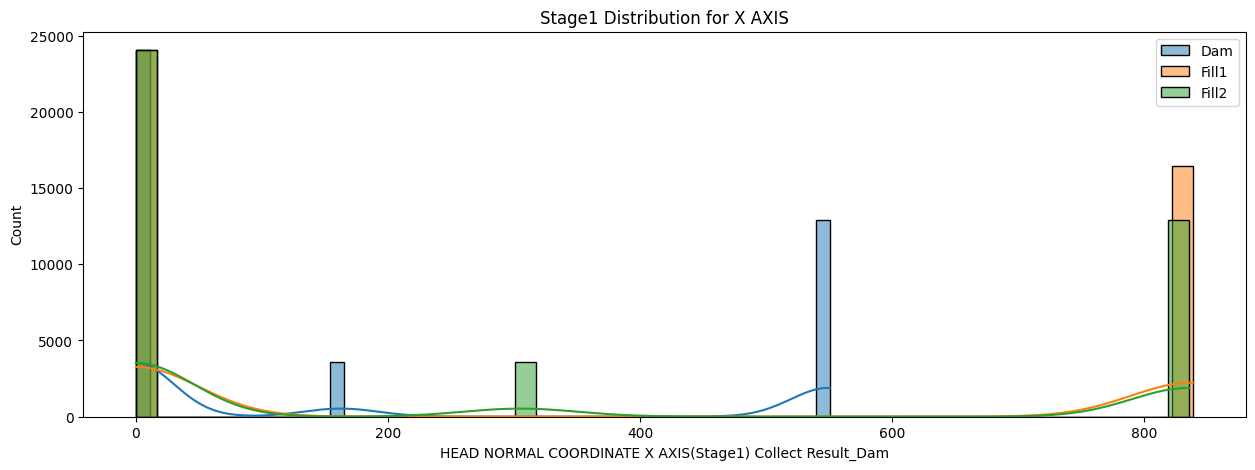

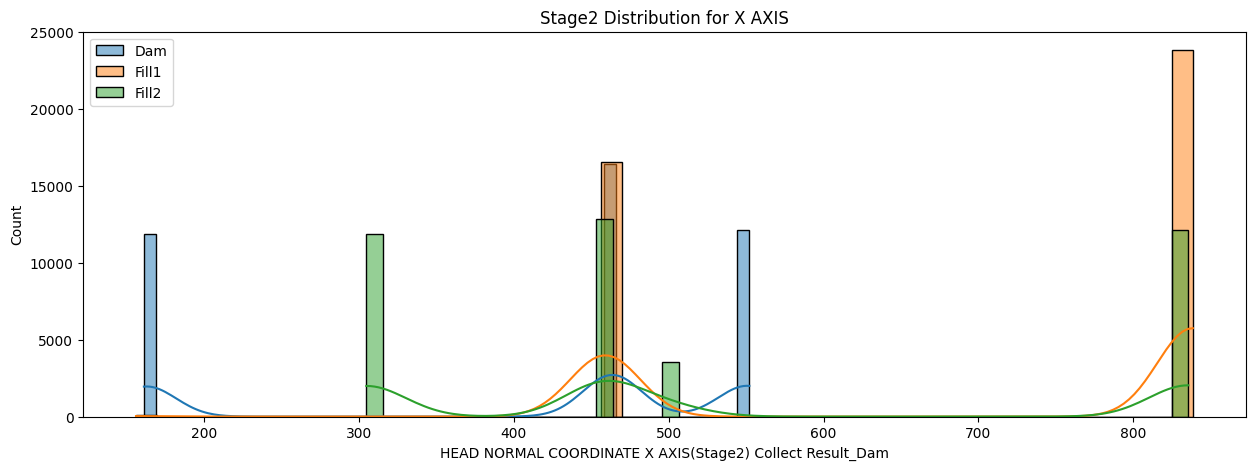

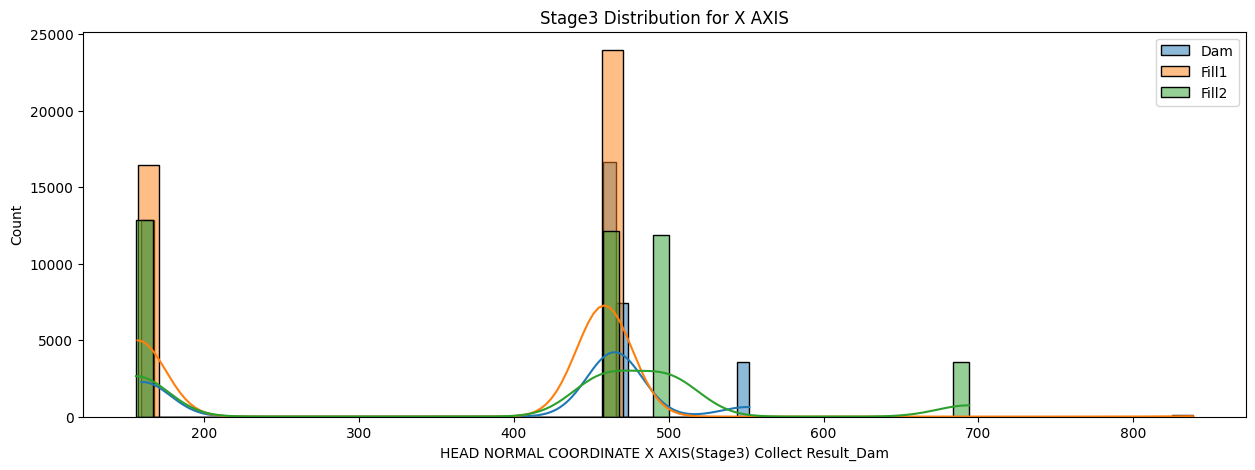

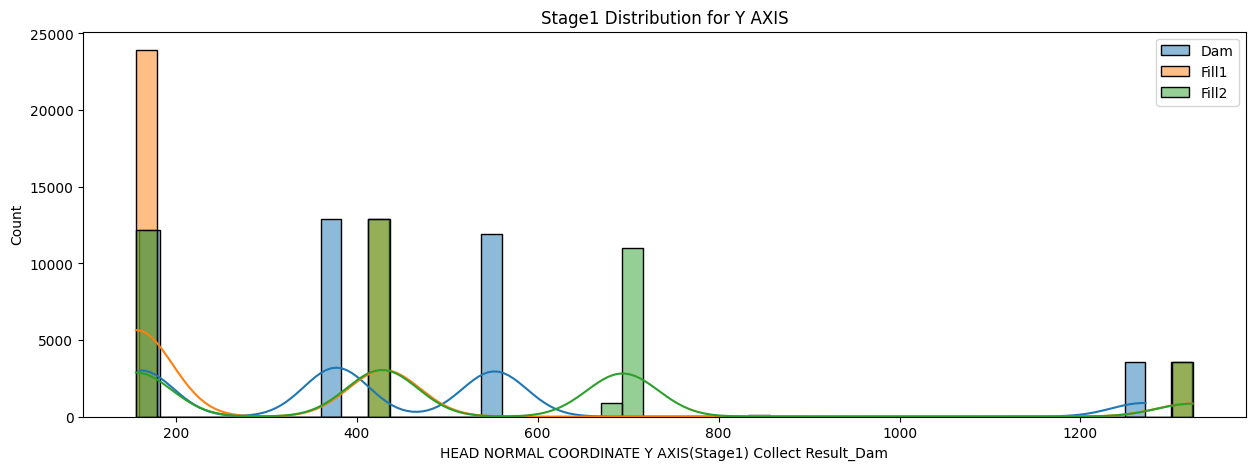

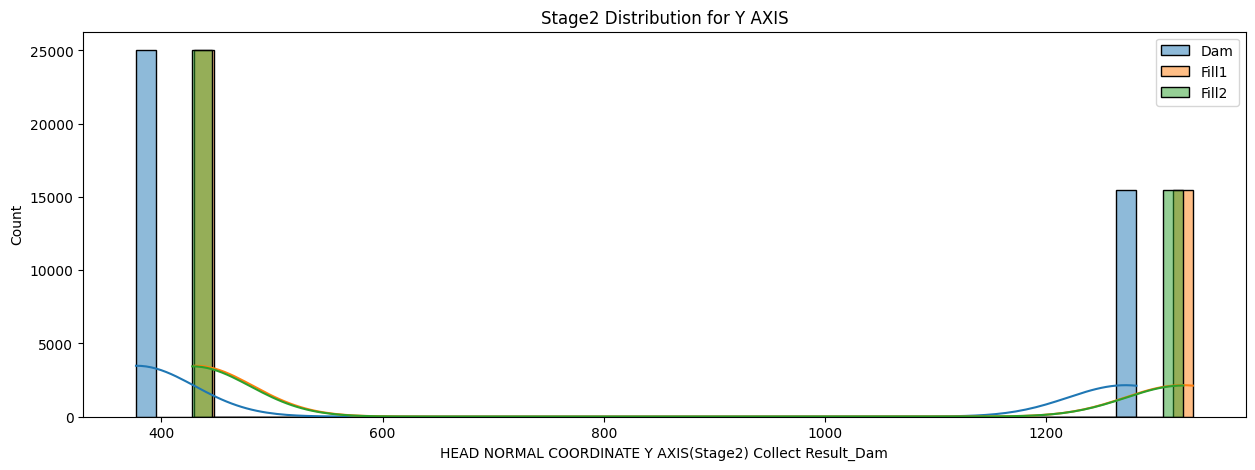

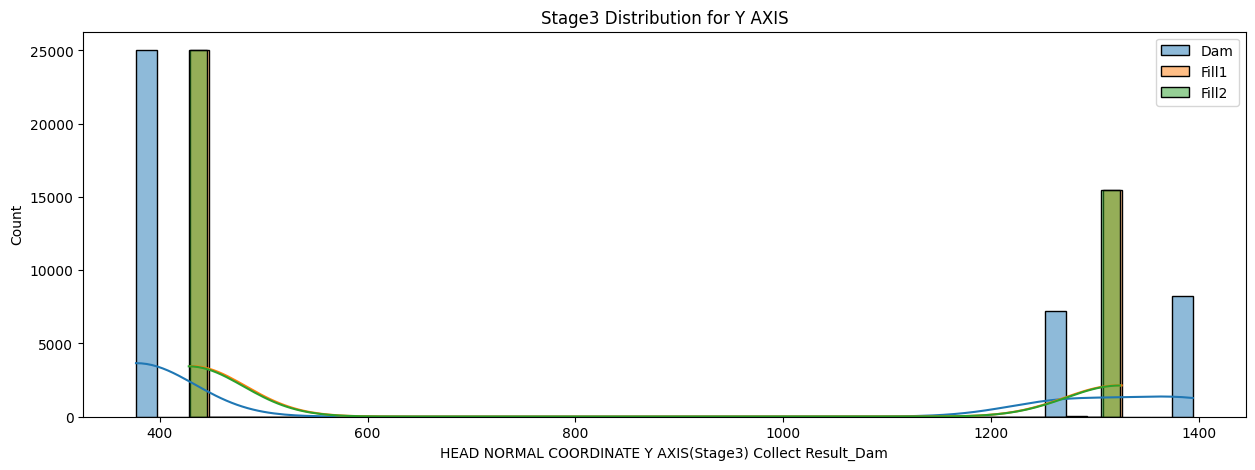

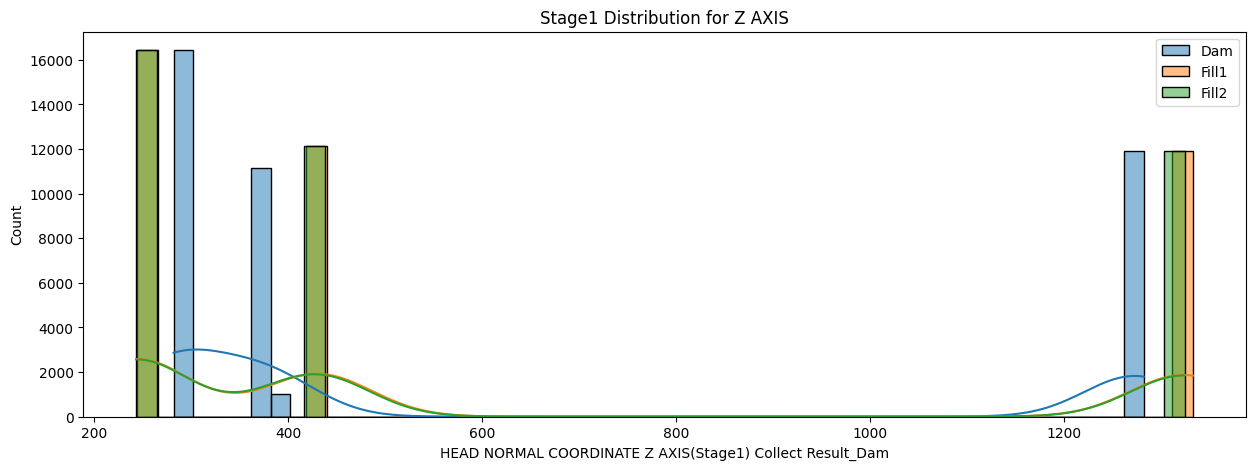

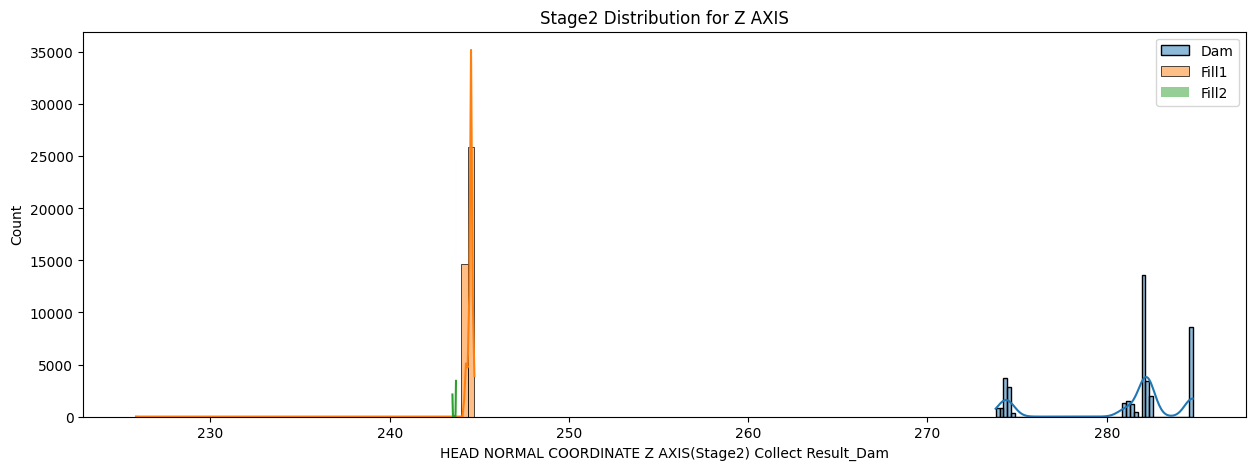

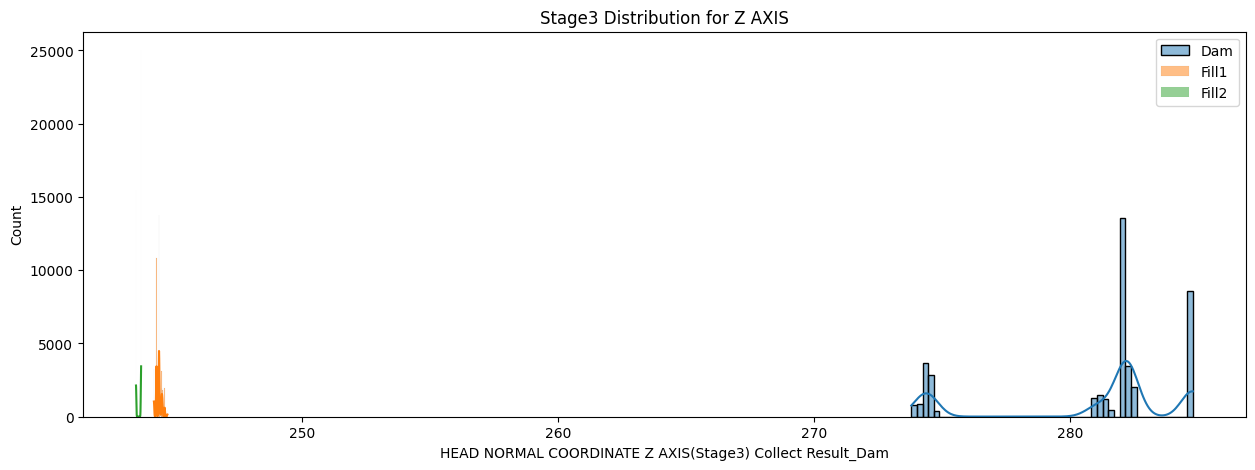

In [372]:
#각 stage별 X,Y,Z 분포도
#이를 통해 결측치 처리 고려
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Y_AXIS와 Z_AXIS 분포도 출력
stages = ['Stage1', 'Stage2', 'Stage3']
axes = ['X AXIS','Y AXIS', 'Z AXIS']
columns_dam_fill = ['Dam', 'Fill1', 'Fill2']

for axis in axes:
    for stage in stages:
        plt.figure(figsize=(15, 5))
        for fill_type in columns_dam_fill:
            col_name = f'HEAD NORMAL COORDINATE {axis}({stage}) Collect Result_{fill_type}'
            sns.histplot(train_data[col_name].dropna(), kde=True, label=f'{fill_type}', bins=50)
        
        plt.title(f'{stage} Distribution for {axis}')
        plt.legend()
        plt.show()

# # 2. 결측치 대체를 위한 처리
# # Y_AXIS와 Z_AXIS의 중앙값으로 X_AXIS(Stage1)의 결측치를 대체

# # Stage1의 각 fill_type에 대해 Y축과 Z축의 중앙값을 계산
# median_values = {}
# for fill_type in columns_dam_fill:
#     y_col_name = f'HEAD NORMAL COORDINATE Y AXIS (Stage1) Collect Result_{fill_type}'
#     z_col_name = f'HEAD NORMAL COORDINATE Z AXIS (Stage1) Collect Result_{fill_type}'
    
#     y_median = train_data[y_col_name].median()
#     z_median = train_data[z_col_name].median()
    
#     median_values[fill_type] = {'Y_AXIS': y_median, 'Z_AXIS': z_median}

# # 결측치가 존재하는 X_AXIS(Stage1) 값 대체
# for fill_type in columns_dam_fill:
#     x_col_name = f'HEAD NORMAL COORDINATE X AXIS (Stage1) Collect Result_{fill_type}'
    
#     # 결측치가 있는 인덱스를 찾고, 해당 인덱스의 X_AXIS 값을 대체
#     missing_indices = train_data[train_data[x_col_name].isnull()].index
    
#     # 결측치 대체 (예: Y축과 Z축의 중앙값 평균으로 대체)
#     for idx in missing_indices:
#         y_median = median_values[fill_type]['Y_AXIS']
#         z_median = median_values[fill_type]['Z_AXIS']
#         x_fill_value = np.mean([y_median, z_median])  # 중앙값 평균으로 대체
#         train_data.loc[idx, x_col_name] = x_fill_value


In [373]:
#결측치 처리 1.
#0과 OK => X axis들의 평균으로 고려
# 각 컬럼에 대해 0인 값을 Stage1의 평균값으로 대체


columns_stage1 = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
]

# 각 컬럼에 대해 처리
for col in columns_stage1:
    # 0이 아닌 값들로 평균 계산
    mean_value = round(train_data[train_data[col] != 0][col].mean(),1)
    
    # 0인 값을 평균으로 대체
    train_data[col] = train_data[col].apply(lambda x: mean_value if x == 0 else x)

# 변경된 데이터 확인
print(train_data[columns_stage1].head())
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].unique())
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].unique())
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].unique())



   HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam  \
0                                              465.2          
1                                              550.3          
2                                              465.2          
3                                              162.4          
4                                              549.0          

   HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1  \
0                                              838.1            
1                                              838.4            
2                                              838.1            
3                                              837.7            
4                                              838.4            

   HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2  
0                                              720.1           
1                                              835.5           
2                                     

In [374]:
# #결측치 처리 2.
# from scipy.spatial.distance import cdist

# # Stage 1의 X Axis, Y Axis, Z Axis 컬럼들
# columns_stage1 = [
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
# ]

# # Y Axis 및 Z Axis 컬럼
# columns_yz_stage1 = [
#     ('HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'),
#     ('HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'),
#     ('HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2')
# ]

# # 각 X Axis 컬럼에 대한 처리
# for (col_x, (col_y, col_z)) in zip(columns_stage1, columns_yz_stage1):
    
#     # 1. 0인 값들을 제외한 데이터 필터링
#     filtered_data = train_data[(train_data[col_x] != 0)]
    
#     # 2. 각 X Axis 값이 가지는 Y Axis와 Z Axis의 평균 계산 (소수점 첫째 자리까지 반올림)
#     mean_values = filtered_data.groupby(col_x)[[col_y, col_z]].mean().round(1).dropna()

#     # 3. X Axis 값이 0인 경우의 Y Axis와 Z Axis 값 추출
#     zero_x_indices = train_data[train_data[col_x] == 0].index
#     zero_yz_values = train_data.loc[zero_x_indices, [col_y, col_z]].values

#     # 4. 해당 Y, Z 값과 가장 가까운 평균 Y, Z 값을 가지는 X Axis 값 찾기
#     distances = cdist(zero_yz_values, mean_values.values)  # YZ 값 간의 거리 계산
#     nearest_indices = distances.argmin(axis=1)  # 가장 가까운 인덱스 찾기
#     nearest_x_values = mean_values.index[nearest_indices]  # 가까운 X Axis 값 가져오기

#     # 5. X Axis 값을 대체
#     train_data.loc[zero_x_indices, col_x] = nearest_x_values

# # 변경된 데이터 확인
# print(train_data[columns_stage1].head())


In [375]:
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].unique())
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].unique())
print(train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].unique())

[465.2 550.3 162.4 549.  549.5 550.  548.5]
[838.1 838.4 837.7 837.9 838.2 837.5]
[720.1 835.5 305. ]


In [376]:
#target_class = LabelEncoder().fit_transform(target_class)

# 매핑 정의
label_mapping = {'Normal': 0, 'AbNormal': 1}

# 매핑을 적용하여 target_class 변환
target_class = np.array([label_mapping[label] for label in target_class])

print(target_class)  # 결과: [0 1 0 1 0]

#normal : 0 , abnormal : 1

[0 0 0 ... 0 0 1]


In [377]:
#label encoding
object_columns = train_data.select_dtypes(include=['object']).columns
for i in object_columns:
    le = LabelEncoder()
    le = le.fit(train_data[i])
    train_data[i] = le.transform(train_data[i])
    
    for label in np.unique(test_data[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_data[i] = le.transform(test_data[i]) 
print('Done.')

Done.


In [378]:
test_data = test_data.drop(columns='Set ID')
train_data.info()
test_data.info() #setID
#target_class : label encoding

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 147 entries, Equipment_Dam to WorkOrder_freq
dtypes: float64(71), int64(76)
memory usage: 45.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Columns: 147 entries, Equipment_Dam to WorkOrder_freq
dtypes: float64(72), int64(75)
memory usage: 19.5 MB


In [379]:
# # 총 작업 시간 계산 (예: 각 공정의 시간 합산)
# time_columns = [
#     '1st Pressure 1st Pressure Unit Time_AutoClave',
#     '2nd Pressure Unit Time_AutoClave',
#     '3rd Pressure Unit Time_AutoClave',
#     'Machine Tact time Collect Result_Dam',
#     'Machine Tact time Collect Result_Fill1',
#     'Machine Tact time Collect Result_Fill2'
# ]

# train_data['Total_Process_Time'] = train_data[time_columns].sum(axis=1)
# test_data['Total_Process_Time'] = test_data[time_columns].sum(axis=1)

# # 장비 이동 거리 계산 (HEAD NORMAL COORDINATE 데이터 사용)
# # 공정 및 스테이지별 HEAD NORMAL COORDINATE 열 정의
# coordinate_columns_template = 'HEAD NORMAL COORDINATE {} AXIS(Stage{}) Collect Result_{}'

# # 공정 목록
# processes = ['Dam', 'Fill1', 'Fill2']

# # 스테이지 목록
# stages = [1, 2, 3]

# # 축 목록
# axes = ['X', 'Y', 'Z']

# # 각 공정의 단계별 이동 거리 계산 및 파생 변수 생성
# for process in processes:
#     for stage in stages:
#         # 현재 스테이지의 X, Y, Z 좌표 열 이름 정의
#         x_col = coordinate_columns_template.format('X', stage, process)
#         y_col = coordinate_columns_template.format('Y', stage, process)
#         z_col = coordinate_columns_template.format('Z', stage, process)

#         # 이동 거리 계산: 스테이지별 X, Y, Z 좌표의 변화량을 계산
#         train_data[f'{process}_Stage{stage}_Movement_Distance'] = np.sqrt(
#             (train_data[x_col] - train_data[x_col].shift(1, fill_value=0))**2 +
#             (train_data[y_col] - train_data[y_col].shift(1, fill_value=0))**2 +
#             (train_data[z_col] - train_data[z_col].shift(1, fill_value=0))**2
#         )
#         test_data[f'{process}_Stage{stage}_Movement_Distance'] = np.sqrt(
#             (test_data[x_col] - test_data[x_col].shift(1, fill_value=0))**2 +
#             (test_data[y_col] - test_data[y_col].shift(1, fill_value=0))**2 +
#             (test_data[z_col] - test_data[z_col].shift(1, fill_value=0))**2
#         )

#     # 각 공정에서의 총 이동 거리 계산 (모든 스테이지에서의 이동 거리 합산)
#     train_data[f'{process}_Total_Movement_Distance'] = train_data[
#         [f'{process}_Stage{stage}_Movement_Distance' for stage in stages]
#     ].sum(axis=1)
    
#     test_data[f'{process}_Total_Movement_Distance'] = test_data[
#         [f'{process}_Stage{stage}_Movement_Distance' for stage in stages]
#     ].sum(axis=1)

# # 공정 속도 효율성 계산
# speed_columns_dam = [
#     'DISCHARGED SPEED OF RESIN Collect Result_Dam',
#     'CURE SPEED Collect Result_Dam'
# ]

# train_data['Resin_Discharge_Efficiency_Dam'] = train_data[speed_columns_dam].mean(axis=1)
# test_data['Resin_Discharge_Efficiency_Dam'] = test_data[speed_columns_dam].mean(axis=1)

# # 품질 지표 파생 변수
# quality_columns = [
#     'Chamber Temp. Judge Value_AutoClave',
#     'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'
# ]

# train_data['Quality_Score'] = train_data[quality_columns].mean(axis=1)
# test_data['Quality_Score'] = test_data[quality_columns].mean(axis=1)



In [380]:
#이상치 처리 고민

#상관계수 고민
def remove_highly_correlated_features(df, threshold):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]
    return df.drop(columns=to_drop), to_drop

train_data, dropped_columns = remove_highly_correlated_features(train_data, 0.9)

# 2. Drop the same columns from test_data
test_data = test_data.drop(columns=dropped_columns)

In [381]:
# Data Scaling
from sklearn.preprocessing import RobustScaler

rbs = RobustScaler()
train_scaled = rbs.fit_transform(train_data)
test_scaled = rbs.transform(test_data)

X_train = pd.DataFrame(train_scaled)
X_test = pd.DataFrame(test_scaled)
target_class
print(X_train.shape)
X_test.info()

(40506, 45)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       17361 non-null  float64
 1   1       17361 non-null  float64
 2   2       17361 non-null  float64
 3   3       17361 non-null  float64
 4   4       17361 non-null  float64
 5   5       17361 non-null  float64
 6   6       17361 non-null  float64
 7   7       17361 non-null  float64
 8   8       17361 non-null  float64
 9   9       17361 non-null  float64
 10  10      17361 non-null  float64
 11  11      17361 non-null  float64
 12  12      17361 non-null  float64
 13  13      17361 non-null  float64
 14  14      17361 non-null  float64
 15  15      17361 non-null  float64
 16  16      17361 non-null  float64
 17  17      17361 non-null  float64
 18  18      17361 non-null  float64
 19  19      17361 non-null  float64
 20  20      17361 non-null  float64
 21  21      17361 non-null 

In [382]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
import lightgbm
import numpy as np

# 데이터 준비
small_cnt = target_class.sum()  # 'AbNormal' 클래스의 개수
large_cnt = len(target_class) - small_cnt  # 'Normal' 클래스의 개수
spw = large_cnt / small_cnt  # 소수 클래스에 대한 가중치 조정 비율

train_x = X_train
train_y = target_class
print(X_train.shape)
print(train_x.shape)
print(train_y.shape)

score = []
result_list = []

for z in range(3):
    skf = StratifiedKFold(n_splits=10, random_state=RANDOM_STATE**z, shuffle=True)  # 총 10번의 fold 진행

    n = 0

    for train_index, valid_index in skf.split(train_x, train_y):  # label 기준으로 stratified k fold 진행
        train_X = np.array(train_x)
        train_Y = np.array(train_y)
        test_X = np.array(X_test)

        X_train, X_valid = train_X[train_index], train_X[valid_index]
        y_train, y_valid = train_Y[train_index], train_Y[valid_index]

        # 모델 학습
        sum_pred = []

        ### XGB
        best_param = {'random_state': RANDOM_STATE,
                      'lambda': 0.07,
                      'alpha': 0.25,
                      'colsample_bytree': 0.82,
                      'subsample': 0.82,
                      'learning_rate': 0.05,
                      'n_estimators': 300,
                      'scale_pos_weight': spw,  # 소수 클래스의 중요도를 조정
                      'max_depth': 10,
                      'min_child_weight': 4}
        model_xgb = XGBClassifier(**best_param)
        model_xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=10)
        preds_2 = model_xgb.predict(X_valid)
        preds_proba_2 = model_xgb.predict_proba(X_valid)
        result_list.append(model_xgb.predict_proba(X_test))
        print("XGB score", f1_score(y_valid, preds_2, average='macro'))

        ## LGB
        lgb_param = {'random_state': RANDOM_STATE,
                     'learning_rate': 0.05,
                     'n_estimators': 301,
                     'scale_pos_weight': spw,
                     'max_depth': 13,
                     'min_child_samples': 10,
                     'subsample': 0.91}
        model_lgbm = LGBMClassifier(**lgb_param)
        fit_params = dict(eval_set=[(X_valid, y_valid)])
        model_lgbm.fit(X_train, y_train, **fit_params, callbacks=[lightgbm.log_evaluation(period=1000, show_stdv=True)])
        preds_3 = model_lgbm.predict(X_valid)
        preds_proba_3 = model_lgbm.predict_proba(X_valid)
        result_list.append(model_lgbm.predict_proba(X_test))
        print("LGB score", f1_score(y_valid, preds_3, average='macro'))

        ## RF
        model_rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, class_weight={0: 1, 1: spw})
        model_rf.fit(X_train, y_train)
        preds_4 = model_rf.predict(X_valid)
        preds_proba_4 = model_rf.predict_proba(X_valid)
        result_list.append(model_rf.predict_proba(X_test))
        print("RF score", f1_score(y_valid, preds_4, average='macro'))

        
        ### SUM
        result = preds_proba_2+preds_proba_3+preds_proba_4

        pred = np.argmax(result, axis=1)
        print(z, "fold", n, "score", f1_score(y_valid, pred, average='macro'))
        score.append(f1_score(y_valid, pred, average='macro'))
        n += 1

print("final_score", sum(score)/30)

(40506, 45)
(40506, 45)
(40506,)
[0]	validation_0-logloss:0.68226
[10]	validation_0-logloss:0.59336
[20]	validation_0-logloss:0.52867
[30]	validation_0-logloss:0.48503
[40]	validation_0-logloss:0.44899
[50]	validation_0-logloss:0.42532
[60]	validation_0-logloss:0.40463
[70]	validation_0-logloss:0.38900
[80]	validation_0-logloss:0.37685
[90]	validation_0-logloss:0.36559
[100]	validation_0-logloss:0.35444
[110]	validation_0-logloss:0.34729
[120]	validation_0-logloss:0.34151
[130]	validation_0-logloss:0.33590
[140]	validation_0-logloss:0.33031
[150]	validation_0-logloss:0.32681
[160]	validation_0-logloss:0.32164
[170]	validation_0-logloss:0.31703
[180]	validation_0-logloss:0.31233
[190]	validation_0-logloss:0.30860
[200]	validation_0-logloss:0.30499
[210]	validation_0-logloss:0.30191
[220]	validation_0-logloss:0.29903
[230]	validation_0-logloss:0.29611
[240]	validation_0-logloss:0.29405
[250]	validation_0-logloss:0.29105
[260]	validation_0-logloss:0.28952
[270]	validation_0-logloss:0.2871

[7000]	valid_0's binary_logloss: 0.360956
[8000]	valid_0's binary_logloss: 0.348517
LGB score 0.5468745256140451
RF score 0.5575595391599049
0 fold 2 score 0.5692280169739186
[0]	validation_0-logloss:0.68115
[10]	validation_0-logloss:0.59379
[20]	validation_0-logloss:0.53462
[30]	validation_0-logloss:0.48766
[40]	validation_0-logloss:0.45536
[50]	validation_0-logloss:0.42809
[60]	validation_0-logloss:0.40788
[70]	validation_0-logloss:0.38893
[80]	validation_0-logloss:0.37508
[90]	validation_0-logloss:0.36392
[100]	validation_0-logloss:0.35442
[110]	validation_0-logloss:0.34740
[120]	validation_0-logloss:0.34130
[130]	validation_0-logloss:0.33689
[140]	validation_0-logloss:0.33212
[150]	validation_0-logloss:0.32658
[160]	validation_0-logloss:0.32271
[170]	validation_0-logloss:0.31908
[180]	validation_0-logloss:0.31601
[190]	validation_0-logloss:0.31255
[200]	validation_0-logloss:0.30839
[210]	validation_0-logloss:0.30384
[220]	validation_0-logloss:0.30113
[230]	validation_0-logloss:0.29

[4000]	valid_0's binary_logloss: 0.39358
[5000]	valid_0's binary_logloss: 0.368626
[6000]	valid_0's binary_logloss: 0.350558
[7000]	valid_0's binary_logloss: 0.336782
[8000]	valid_0's binary_logloss: 0.324854
LGB score 0.5712536161033778
RF score 0.5433481762652818
0 fold 5 score 0.5683701144733576
[0]	validation_0-logloss:0.68254
[10]	validation_0-logloss:0.58834
[20]	validation_0-logloss:0.52513
[30]	validation_0-logloss:0.48230
[40]	validation_0-logloss:0.44880
[50]	validation_0-logloss:0.42385
[60]	validation_0-logloss:0.40542
[70]	validation_0-logloss:0.39185
[80]	validation_0-logloss:0.38020
[90]	validation_0-logloss:0.36760
[100]	validation_0-logloss:0.36013
[110]	validation_0-logloss:0.35122
[120]	validation_0-logloss:0.34376
[130]	validation_0-logloss:0.33961
[140]	validation_0-logloss:0.33337
[150]	validation_0-logloss:0.32716
[160]	validation_0-logloss:0.32251
[170]	validation_0-logloss:0.31834
[180]	validation_0-logloss:0.31469
[190]	validation_0-logloss:0.30964
[200]	valid

[1000]	valid_0's binary_logloss: 0.53411
[2000]	valid_0's binary_logloss: 0.473727
[3000]	valid_0's binary_logloss: 0.430878
[4000]	valid_0's binary_logloss: 0.402271
[5000]	valid_0's binary_logloss: 0.379078
[6000]	valid_0's binary_logloss: 0.360953
[7000]	valid_0's binary_logloss: 0.346454
[8000]	valid_0's binary_logloss: 0.33399
LGB score 0.5699571726896259
RF score 0.5814099402118424
0 fold 8 score 0.6007320294313434
[0]	validation_0-logloss:0.68250
[10]	validation_0-logloss:0.59496
[20]	validation_0-logloss:0.53092
[30]	validation_0-logloss:0.48731
[40]	validation_0-logloss:0.45381
[50]	validation_0-logloss:0.42980
[60]	validation_0-logloss:0.40972
[70]	validation_0-logloss:0.39384
[80]	validation_0-logloss:0.38216
[90]	validation_0-logloss:0.37198
[100]	validation_0-logloss:0.36290
[110]	validation_0-logloss:0.35370
[120]	validation_0-logloss:0.34701
[130]	validation_0-logloss:0.34117
[140]	validation_0-logloss:0.33635
[150]	validation_0-logloss:0.33068
[160]	validation_0-logloss

[1000]	valid_0's binary_logloss: 0.522677
[2000]	valid_0's binary_logloss: 0.463049
[3000]	valid_0's binary_logloss: 0.420459
[4000]	valid_0's binary_logloss: 0.390236
[5000]	valid_0's binary_logloss: 0.366676
[6000]	valid_0's binary_logloss: 0.347649
[7000]	valid_0's binary_logloss: 0.332974
[8000]	valid_0's binary_logloss: 0.320637
LGB score 0.5785519091158746
RF score 0.5638502947962061
1 fold 1 score 0.6051143748375357
[0]	validation_0-logloss:0.68380
[10]	validation_0-logloss:0.59521
[20]	validation_0-logloss:0.53075
[30]	validation_0-logloss:0.48630
[40]	validation_0-logloss:0.45104
[50]	validation_0-logloss:0.42750
[60]	validation_0-logloss:0.40715
[70]	validation_0-logloss:0.39114
[80]	validation_0-logloss:0.37693
[90]	validation_0-logloss:0.36586
[100]	validation_0-logloss:0.35703
[110]	validation_0-logloss:0.34993
[120]	validation_0-logloss:0.34194
[130]	validation_0-logloss:0.33530
[140]	validation_0-logloss:0.33037
[150]	validation_0-logloss:0.32630
[160]	validation_0-loglo

[1000]	valid_0's binary_logloss: 0.533032
[2000]	valid_0's binary_logloss: 0.477401
[3000]	valid_0's binary_logloss: 0.437748
[4000]	valid_0's binary_logloss: 0.405972
[5000]	valid_0's binary_logloss: 0.382437
[6000]	valid_0's binary_logloss: 0.364601
[7000]	valid_0's binary_logloss: 0.349351
[8000]	valid_0's binary_logloss: 0.338869
LGB score 0.5565856698607732
RF score 0.5523599880728957
1 fold 4 score 0.5831757766579464
[0]	validation_0-logloss:0.68245
[10]	validation_0-logloss:0.59795
[20]	validation_0-logloss:0.53065
[30]	validation_0-logloss:0.48761
[40]	validation_0-logloss:0.45135
[50]	validation_0-logloss:0.42649
[60]	validation_0-logloss:0.40572
[70]	validation_0-logloss:0.38788
[80]	validation_0-logloss:0.37561
[90]	validation_0-logloss:0.36488
[100]	validation_0-logloss:0.35702
[110]	validation_0-logloss:0.34967
[120]	validation_0-logloss:0.34340
[130]	validation_0-logloss:0.33798
[140]	validation_0-logloss:0.33180
[150]	validation_0-logloss:0.32628
[160]	validation_0-loglo

[1000]	valid_0's binary_logloss: 0.536906
[2000]	valid_0's binary_logloss: 0.479373
[3000]	valid_0's binary_logloss: 0.438134
[4000]	valid_0's binary_logloss: 0.406376
[5000]	valid_0's binary_logloss: 0.383803
[6000]	valid_0's binary_logloss: 0.368986
[7000]	valid_0's binary_logloss: 0.356579
[8000]	valid_0's binary_logloss: 0.346506
LGB score 0.5644444444444445
RF score 0.560287634593926
1 fold 7 score 0.5776166314457043
[0]	validation_0-logloss:0.68230
[10]	validation_0-logloss:0.59325
[20]	validation_0-logloss:0.52669
[30]	validation_0-logloss:0.48104
[40]	validation_0-logloss:0.44794
[50]	validation_0-logloss:0.42203
[60]	validation_0-logloss:0.40339
[70]	validation_0-logloss:0.38744
[80]	validation_0-logloss:0.37135
[90]	validation_0-logloss:0.36046
[100]	validation_0-logloss:0.35214
[110]	validation_0-logloss:0.34753
[120]	validation_0-logloss:0.34013
[130]	validation_0-logloss:0.33337
[140]	validation_0-logloss:0.32904
[150]	validation_0-logloss:0.32328
[160]	validation_0-loglos

[1000]	valid_0's binary_logloss: 0.527159
[2000]	valid_0's binary_logloss: 0.47042
[3000]	valid_0's binary_logloss: 0.430583
[4000]	valid_0's binary_logloss: 0.398664
[5000]	valid_0's binary_logloss: 0.373889
[6000]	valid_0's binary_logloss: 0.354574
[7000]	valid_0's binary_logloss: 0.339549
[8000]	valid_0's binary_logloss: 0.32707
LGB score 0.5790670475030568
RF score 0.5543713884521059
2 fold 0 score 0.5900146435176685
[0]	validation_0-logloss:0.68315
[10]	validation_0-logloss:0.59133
[20]	validation_0-logloss:0.52858
[30]	validation_0-logloss:0.48793
[40]	validation_0-logloss:0.45449
[50]	validation_0-logloss:0.42985
[60]	validation_0-logloss:0.41139
[70]	validation_0-logloss:0.39459
[80]	validation_0-logloss:0.38124
[90]	validation_0-logloss:0.37181
[100]	validation_0-logloss:0.36330
[110]	validation_0-logloss:0.35720
[120]	validation_0-logloss:0.35182
[130]	validation_0-logloss:0.34802
[140]	validation_0-logloss:0.34296
[150]	validation_0-logloss:0.33611
[160]	validation_0-logloss

[1000]	valid_0's binary_logloss: 0.523977
[2000]	valid_0's binary_logloss: 0.46458
[3000]	valid_0's binary_logloss: 0.422877
[4000]	valid_0's binary_logloss: 0.391391
[5000]	valid_0's binary_logloss: 0.368338
[6000]	valid_0's binary_logloss: 0.350064
[7000]	valid_0's binary_logloss: 0.336201
[8000]	valid_0's binary_logloss: 0.324569
LGB score 0.5701876910018425
RF score 0.5438704110053002
2 fold 3 score 0.5908442435643315
[0]	validation_0-logloss:0.68228
[10]	validation_0-logloss:0.59464
[20]	validation_0-logloss:0.53043
[30]	validation_0-logloss:0.49033
[40]	validation_0-logloss:0.45365
[50]	validation_0-logloss:0.42866
[60]	validation_0-logloss:0.40804
[70]	validation_0-logloss:0.39031
[80]	validation_0-logloss:0.37880
[90]	validation_0-logloss:0.36681
[100]	validation_0-logloss:0.35798
[110]	validation_0-logloss:0.35201
[120]	validation_0-logloss:0.34608
[130]	validation_0-logloss:0.34179
[140]	validation_0-logloss:0.33550
[150]	validation_0-logloss:0.33080
[160]	validation_0-loglos

[1000]	valid_0's binary_logloss: 0.531595
[2000]	valid_0's binary_logloss: 0.472543
[3000]	valid_0's binary_logloss: 0.431373
[4000]	valid_0's binary_logloss: 0.398721
[5000]	valid_0's binary_logloss: 0.376127
[6000]	valid_0's binary_logloss: 0.355812
[7000]	valid_0's binary_logloss: 0.341324
[8000]	valid_0's binary_logloss: 0.329069
LGB score 0.5638629876670621
RF score 0.5591380973843811
2 fold 6 score 0.5868564358518993
[0]	validation_0-logloss:0.68393
[10]	validation_0-logloss:0.59797
[20]	validation_0-logloss:0.53626
[30]	validation_0-logloss:0.49296
[40]	validation_0-logloss:0.45734
[50]	validation_0-logloss:0.43445
[60]	validation_0-logloss:0.41507
[70]	validation_0-logloss:0.39893
[80]	validation_0-logloss:0.38267
[90]	validation_0-logloss:0.37005
[100]	validation_0-logloss:0.36038
[110]	validation_0-logloss:0.35334
[120]	validation_0-logloss:0.34560
[130]	validation_0-logloss:0.33950
[140]	validation_0-logloss:0.33373
[150]	validation_0-logloss:0.32851
[160]	validation_0-loglo

[1000]	valid_0's binary_logloss: 0.524936
[2000]	valid_0's binary_logloss: 0.468277
[3000]	valid_0's binary_logloss: 0.429098
[4000]	valid_0's binary_logloss: 0.398179
[5000]	valid_0's binary_logloss: 0.376051
[6000]	valid_0's binary_logloss: 0.357342
[7000]	valid_0's binary_logloss: 0.343317
[8000]	valid_0's binary_logloss: 0.333143
LGB score 0.55465479585027
RF score 0.5591380973843811
2 fold 9 score 0.5716420770262503
final_score 0.5822800789200121


In [383]:
result = np.array(result_list[0])

for i in range(1, len(result_list)):
    result += result_list[i]

cls_data = np.argmax(result, axis = 1)

In [384]:
cls_data


array([0, 0, 0, ..., 0, 0, 0])

In [385]:
test_pred = pd.Series(cls_data).map({0: 'Normal', 1: 'AbNormal'})
value_counts = test_pred.value_counts()
print(value_counts)
test_pred

Normal      16696
AbNormal      665
Name: count, dtype: int64


0        Normal
1        Normal
2        Normal
3        Normal
4        Normal
          ...  
17356    Normal
17357    Normal
17358    Normal
17359    Normal
17360    Normal
Length: 17361, dtype: object

In [386]:
# 제출 파일 작성
submission_data = pd.read_csv("submission.csv")
TARGET = 'target'  # TARGET 변수를 실제 submission 파일에 맞는 컬럼 이름으로 설정

# 제출 데이터에 예측 결과를 추가
submission_data[TARGET] = test_pred

# 제출 파일로 저장
submission_data.to_csv("submission.csv", index=False)
print('File Saved!')

File Saved!
